<a href="https://colab.research.google.com/github/zhangxs131/TTS_trying/blob/main/%E2%80%9C_Chinese_TensorflowTTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 基于TensorflowTTS 中文端到端的语音合成系统




中文端到端的语音合成系统 (Using Baker dataset)

Github: https://github.com/TensorSpeech/TensorflowTTS

Colab for Eng: https://colab.research.google.com/drive/1akxtrLZHKuMiQup00tzO2olCaN-y3KiD?usp=sharing


## 安装依赖


In [1]:
import os
os.system("rm -rf TensorFlowTTS")
!git clone https://github.com/TensorSpeech/TensorFlowTTS.git
os.chdir("TensorFlowTTS")
!pip install .
os.chdir("..")
import sys
sys.path.append("TensorFlowTTS/")

Cloning into 'TensorFlowTTS'...
remote: Enumerating objects: 10679, done.
remote: Total 10679 (delta 0), reused 0 (delta 0), pack-reused 10679
Receiving objects: 100% (10679/10679), 133.52 MiB | 23.15 MiB/s, done.
Resolving deltas: 100% (5163/5163), done.
Processing /content/TensorFlowTTS
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 489.6 MB 23 kB/s 
     |████████████████████████████████| 1.1 MB 54.4 MB/s 
     |████████████████████████████████| 235 kB 59.0 MB/s 
     |████████████████████████████████| 212 kB 58.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ...

In [2]:
!pip install git+https://github.com/repodiac/german_transliterate.git#egg=german_transliterate
!pip install h5py==2.10.0

  Cloning https://github.com/repodiac/german_transliterate.git to /tmp/pip-install-zsef6zys/german-transliterate_8f40f0826bb4471797b117de66775b8a
  Running command git clone -q https://github.com/repodiac/german_transliterate.git /tmp/pip-install-zsef6zys/german-transliterate_8f40f0826bb4471797b117de66775b8a
     |████████████████████████████████| 101 kB 4.9 MB/s 
  Created wheel for german-transliterate: filename=german_transliterate-0.1.3-py3-none-any.whl size=20829 sha256=f94401a4e6ecae9f6716530f8bcbc2d84e538cf061030edc6f16e774316bce60
  Stored in directory: /tmp/pip-ephem-wheel-cache-0sotcumm/wheels/77/17/55/6c6d2d33bd2b3b8a3741e12b17f0b18278861f64858bbcc228
Successfully built german-transliterate
     |████████████████████████████████| 2.9 MB 7.5 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages t

## Load Model

In [3]:
import tensorflow as tf

import yaml
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoProcessor

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


### Tacotron2


In [4]:
tacotron2 = TFAutoModel.from_pretrained("tensorspeech/tts-tacotron2-baker-ch", name="tacotron2")

Downloading:   0%|          | 0.00/129M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

### FastSpeech2

In [14]:
fastspeech2 = TFAutoModel.from_pretrained("tensorspeech/tts-fastspeech2-baker-ch", name="fastspeech2")

Downloading:   0%|          | 0.00/65.5M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.85k [00:00<?, ?B/s]

### MB-MelGAN

In [5]:
mb_melgan = TFAutoModel.from_pretrained("tensorspeech/tts-mb_melgan-baker-ch", name="mb_melgan")

Downloading:   0%|          | 0.00/7.54M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.82k [00:00<?, ?B/s]

## Inference

In [6]:
processor = AutoProcessor.from_pretrained("tensorspeech/tts-tacotron2-baker-ch")

Downloading:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

In [7]:
def do_synthesis(input_text, text2mel_model, vocoder_model, text2mel_name, vocoder_name):
  input_ids = processor.text_to_sequence(input_text, inference=True)

  # text2mel part
  if text2mel_name == "TACOTRON":
    _, mel_outputs, stop_token_prediction, alignment_history = text2mel_model.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        tf.convert_to_tensor([len(input_ids)], tf.int32),
        tf.convert_to_tensor([0], dtype=tf.int32)
    )
  elif text2mel_name == "FASTSPEECH2":
    mel_before, mel_outputs, duration_outputs, _, _ = text2mel_model.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
        speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
        f0_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
        energy_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    )
  else:
    raise ValueError("Only TACOTRON, FASTSPEECH2 are supported on text2mel_name")

  # vocoder part
  if vocoder_name == "MB-MELGAN":
    # tacotron-2 generate noise in the end symtematic, let remove it :v.
    if text2mel_name == "TACOTRON":
      remove_end = 1024
    else:
      remove_end = 1
    audio = vocoder_model.inference(mel_outputs)[0, :-remove_end, 0]
  else:
    raise ValueError("Only MB_MELGAN are supported on vocoder_name")

  if text2mel_name == "TACOTRON":
    return mel_outputs.numpy(), alignment_history.numpy(), audio.numpy()
  else:
    return mel_outputs.numpy(), audio.numpy()

def visualize_attention(alignment_history):
  import matplotlib.pyplot as plt

  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111)
  ax.set_title(f'Alignment steps')
  im = ax.imshow(
      alignment_history,
      aspect='auto',
      origin='lower',
      interpolation='none')
  fig.colorbar(im, ax=ax)
  xlabel = 'Decoder timestep'
  plt.xlabel(xlabel)
  plt.ylabel('Encoder timestep')
  plt.tight_layout()
  plt.show()
  plt.close()

def visualize_mel_spectrogram(mels):
  mels = tf.reshape(mels, [-1, 80]).numpy()
  fig = plt.figure(figsize=(10, 8))
  ax1 = fig.add_subplot(311)
  ax1.set_title(f'Predicted Mel-after-Spectrogram')
  im = ax1.imshow(np.rot90(mels), aspect='auto', interpolation='none')
  fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
  plt.show()
  plt.close()

In [11]:
input_text = "五年 过去了，小舞 更美了，她 长高了 少许，也 丰满了 少许，身上的 那份青涩 已经 完全 化为了 绝美的 代言。一双 柔光闪烁的 大眼睛 俯视着 湖对面的 武魂殿一行人，仿佛 周围的一切 都是以她为中心，现在的她，就像是 已经化身为 森林女神 一般，静静的 站在 那无比雄壮的 泰坦巨猿肩头。"

In [12]:
# setup window for tacotron2 if you want to try
tacotron2.setup_window(win_front=5, win_back=5)

### Tacotron2 + MB-MelGAN

phoneme seq: sil ^ u3 #0 n ian2 #0 g uo4 #0 q v4 #0 l e5 #0 x iao3 #0 ^ u3 #0 g eng4 #0 m ei3 #0 l e5 #0 t a1 #0 zh ang3 #0 g ao1 #0 l e5 #0 sh ao3 #0 x v3 #0 ^ ie3 #0 f eng1 #0 m an3 #0 l e5 #0 sh ao3 #0 x v3 #0 sh en1 #0 sh ang4 #0 d e5 #0 n a4 #0 f en4 #0 q ing1 #0 s e4 #0 ^ i3 #0 j ing1 #0 ^ uan2 #0 q van2 #0 h ua4 #0 ^ uei4 #0 l e5 #0 j ve2 #0 m ei3 #0 d e5 #0 d ai4 #0 ^ ian2 #0 ^ i1 #0 sh uang1 #0 r ou2 #0 g uang1 #0 sh an3 #0 sh uo4 #0 d e5 #0 d a4 #0 ^ ian3 #0 j ing1 #0 f u3 #0 sh iii4 #0 zh e5 #0 h u2 #0 d uei4 #0 m ian4 #0 d e5 #0 ^ u3 #0 h uen2 #0 d ian4 #0 ^ i1 #0 x ing2 #0 r en2 #0 f ang3 #0 f u2 #0 zh ou1 #0 ^ uei2 #0 d e5 #0 ^ i1 #0 q ie4 #0 d ou1 #0 sh iii4 #0 ^ i3 #0 t a1 #0 ^ uei4 #0 zh ong1 #0 x in1 #0 x ian4 #0 z ai4 #0 d e5 #0 t a1 #0 j iou4 #0 x iang4 #0 sh iii4 #0 ^ i3 #0 j ing1 #0 h ua4 #0 sh en1 #0 ^ uei4 #0 s en1 #0 l in2 #0 n v3 #0 sh en2 #0 ^ i4 #0 b an1 #0 j ing4 #0 j ing4 #0 d e5 #0 zh an4 #0 z ai4 #0 n a4 #0 ^ u2 #0 b i3 #0 x iong2 #0 zh uang4 #0 d e5 #0 

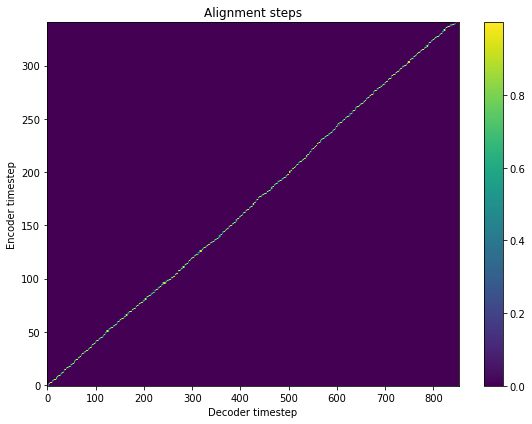

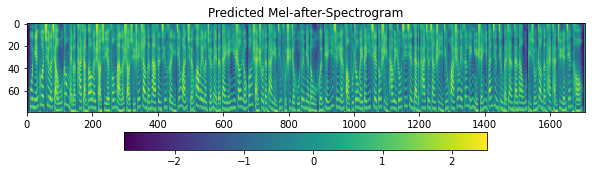

In [13]:
mels, alignment_history, audios = do_synthesis(input_text, tacotron2, mb_melgan, "TACOTRON", "MB-MELGAN")
visualize_attention(alignment_history[0])
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=24000)

### FastSpeech2 + MB-MelGAN

phoneme seq: sil ^ u3 #0 n ian2 #0 g uo4 #0 q v4 #0 l e5 #0 x iao3 #0 ^ u3 #0 g eng4 #0 m ei3 #0 l e5 #0 t a1 #0 zh ang3 #0 g ao1 #0 l e5 #0 sh ao3 #0 x v3 #0 ^ ie3 #0 f eng1 #0 m an3 #0 l e5 #0 sh ao3 #0 x v3 #0 sh en1 #0 sh ang4 #0 d e5 #0 n a4 #0 f en4 #0 q ing1 #0 s e4 #0 ^ i3 #0 j ing1 #0 ^ uan2 #0 q van2 #0 h ua4 #0 ^ uei4 #0 l e5 #0 j ve2 #0 m ei3 #0 d e5 #0 d ai4 #0 ^ ian2 #0 ^ i1 #0 sh uang1 #0 r ou2 #0 g uang1 #0 sh an3 #0 sh uo4 #0 d e5 #0 d a4 #0 ^ ian3 #0 j ing1 #0 f u3 #0 sh iii4 #0 zh e5 #0 h u2 #0 d uei4 #0 m ian4 #0 d e5 #0 ^ u3 #0 h uen2 #0 d ian4 #0 ^ i1 #0 x ing2 #0 r en2 #0 f ang3 #0 f u2 #0 zh ou1 #0 ^ uei2 #0 d e5 #0 ^ i1 #0 q ie4 #0 d ou1 #0 sh iii4 #0 ^ i3 #0 t a1 #0 ^ uei4 #0 zh ong1 #0 x in1 #0 x ian4 #0 z ai4 #0 d e5 #0 t a1 #0 j iou4 #0 x iang4 #0 sh iii4 #0 ^ i3 #0 j ing1 #0 h ua4 #0 sh en1 #0 ^ uei4 #0 s en1 #0 l in2 #0 n v3 #0 sh en2 #0 ^ i4 #0 b an1 #0 j ing4 #0 j ing4 #0 d e5 #0 zh an4 #0 z ai4 #0 n a4 #0 ^ u2 #0 b i3 #0 x iong2 #0 zh uang4 #0 d e5 #0 

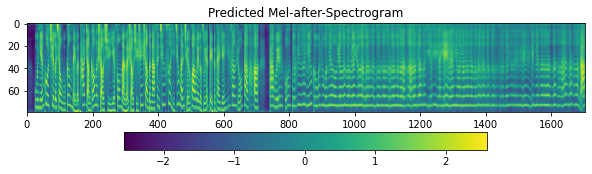

In [15]:
mels, audios = do_synthesis(input_text, fastspeech2, mb_melgan, "FASTSPEECH2", "MB-MELGAN")
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=24000)

这他妈说啥呢，服了，这垃圾TTS，enlish还凑合，这汉语真是垃圾